An initial attempt at a study justifying the number of iterations used for Uni-/MultiFold.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Generic imports
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import livelossplot
import tensorflow as tf
from livelossplot import PlotLossesKeras

### Custom functions
from omnifold import *
from omnifold.utilities import *

In [3]:
### GPU Setup
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number between 0 & 3
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-10-06 11:02:57.393852: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-06 11:02:57.423333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-10-06 11:02:57.424655: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-06 11:02:57.445111: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-06 11:02:57.457866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-10-06 11:02:57.460999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [6]:
plot_setup()
plt.rcParams.update({"font.family": "serif",})

In [7]:
plot_dir = './plots/'

### Load files

Since we're not using data yet, "MC" = Powheg + Pythia8 MC16e and "data" = Sherpa 2.2.1 MC16e.

In [8]:
folder = '/clusterfs/ml4hep/adisurtya/ATLASOmniFold/slimmedSamples/'

In [9]:
f_mc = uproot.open(folder+"ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root")
f_data = uproot.open(folder+"ZjetOmnifold_Jun25_Sherpa221_mc16e_slim.root")

In [10]:
columns = f_mc['OmniTree'].keys()

These columns are the same for both samples, since they're both MC:

In [11]:
f_mc['OmniTree'].keys() == f_data['OmniTree'].keys()

True

Note that variables ending in `_tracks` require MultiIndex-ing. It's possible to combine these with flat variables, but it does increase the size of the DataFrame considerably: 

In [12]:
# [col for col in columns if col.endswith("_tracks")]

In [13]:
# f_mc['OmniTree'].arrays(
#     ["weight","pT_tracks"],
#     library="pd")

Let's ignore the MultiIndex variables for now.

In [14]:
mc = f_mc['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

data = f_data['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

print("MC has {:,} events with {} columns.".format(mc.shape[0],mc.shape[1]))
print("Data has {:,} events with {} columns.".format(data.shape[0],data.shape[1]))

MC has 416,725 events with 57 columns.
Data has 3,578,623 events with 57 columns.


### Apply event selection

In [15]:
mc['pass190'] = mc['pass190'].astype('bool')
mc['truth_pass190'] = mc['truth_pass190'].astype('bool')
data['pass190'] = data['pass190'].astype('bool')
data['truth_pass190'] = data['truth_pass190'].astype('bool')

In [16]:
### The sample we're using already has these cuts applied, but we'll keep them in for future datasets. 
mc_truth_weights = mc[(mc.pass190 | mc.truth_pass190)].weight_mc
mc_reco_weights = mc[(mc.pass190 | mc.truth_pass190)].weight

data_truth_weights = data[data.truth_pass190].weight_mc
data_reco_weights = data[data.pass190].weight

In [77]:
## JUST FOR FUN/OPTIONAL: add a large offset to 10% of the true data, for fun
# data_truth_weights[:343775] = data_truth_weights[:343775]*10

Normalize the weights:

In [17]:
for weights in [mc_truth_weights, mc_reco_weights, data_truth_weights, data_reco_weights]:
    weights /= np.mean(weights)

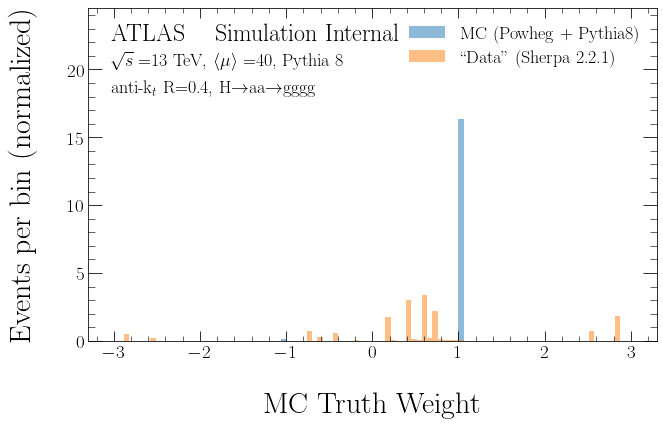

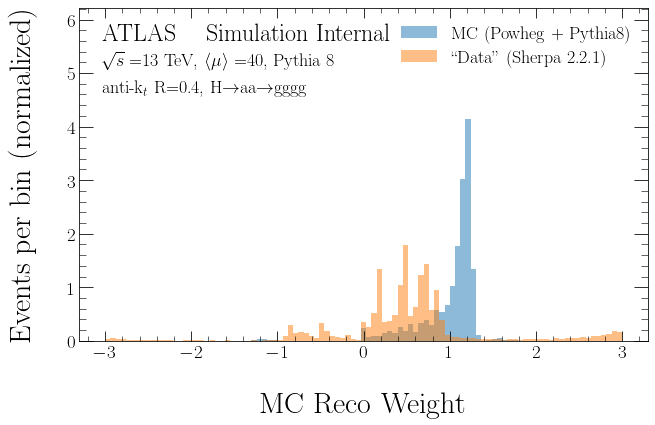

In [18]:
bins = np.linspace(-3, 3, 100)

plt.figure(figsize=(10, 6))
hW_sim_truth, _, _ = plt.hist(mc_truth_weights,
                              bins=bins,
                              label=r'MC (Powheg + Pythia8)',
                              **plot_style_2)
hW_data_truth, _, _ = plt.hist(data_truth_weights,
                               bins=bins,
                               label=r'``Data" (Sherpa 2.2.1)',
                               **plot_style_2)
plt.xlabel('MC Truth Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_truth, hW_data_truth)))
plt.legend()
draw_atlas_text()
plt.show()

plt.figure(figsize=(10, 6))
hW_sim_reco, _, _ = plt.hist(mc_reco_weights,
                             bins=bins,
                             label=r'MC (Powheg + Pythia8)',
                             **plot_style_2)
hW_data_reco, _, _ = plt.hist(data_reco_weights,
                              bins=bins,
                              label=r'``Data" (Sherpa 2.2.1)',
                              **plot_style_2)
plt.xlabel('MC Reco Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_reco, hW_data_reco)))
plt.legend()
draw_atlas_text()
plt.show()

### Load IBU histograms for comparison

In [19]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]
plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

In [20]:
IBU_hists = uproot.open('/clusterfs/ml4hep/adisurtya/ATLASOmniFold/unfoldingPlotsJune14_UnfoldedHists.root')

bins = []
for label in file_labels:
    bins += [IBU_hists['SherpaUnfoldWPythia_2018_'+label].to_numpy()[1]]

In [21]:
labels_and_bins = zip(file_labels, plot_labels, bins)

ibu_hists = []

for file_label, plot_label, plot_bins in labels_and_bins:
    ibu_hists += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

### Unifold

In [22]:
K.clear_session()

In [23]:
unifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_truth_weights)))

In [24]:
unifold_weights.shape # (n_variables, n_events)

(24, 416725)

In [25]:
save_label0 = 'iteration_10times'

In [26]:
i = 0 # index of variable of interest (num_tracks for leading jet)
bins = ibu_hists[i]['bins']
x_label = ibu_hists[i]['plot_label']
file_label = ibu_hists[i]['file_label']
save_label = plot_dir+'UniFold/'+file_label+'/'+save_label0
print("Saving as {}.".format(save_label))

Saving as ./plots/UniFold/Ntracks_trackj1/iteration_10times.


Grab the particular variable you care about, and set a dummy value for events that don't pass each MC selection:

In [27]:
dummyval = -99
mc_truth = mc[(mc.pass190 | mc.truth_pass190)]['truth_' + file_label]
mc_truth[mc.truth_pass190 == False] = dummyval
mc_reco = mc[(mc.pass190 | mc.truth_pass190)][file_label]
mc_reco[mc.pass190 == False] = dummyval

data_truth = data[data['truth_pass190']]['truth_' + file_label]
data_reco = data[data['pass190']][file_label]

Plot this observable in MC & "data" before unfolding:

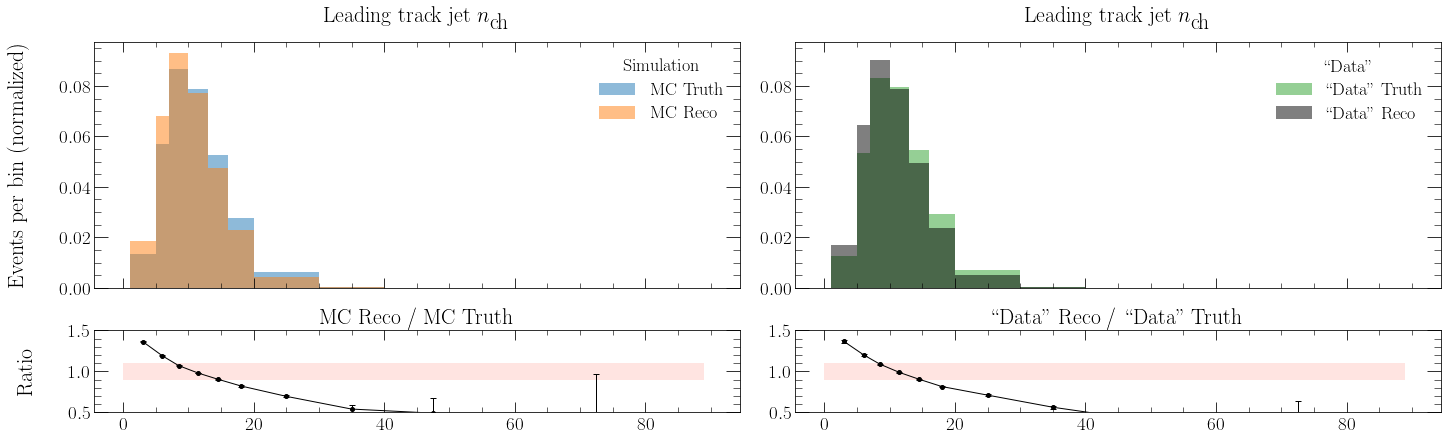

In [28]:
plot_distributions(
    sim_truth=mc_truth,
    sim_reco=mc_reco,
    sim_truth_weights_MC=mc_truth_weights,
    sim_reco_weights_MC=mc_reco_weights,
    data_truth=data_truth,
    data_reco=data_reco,
    data_truth_weights_MC=data_truth_weights,
    data_reco_weights_MC=data_reco_weights,
    bins=bins,
    x_label=x_label,
    save_label=save_label
)

Standardize the data by z-score:

In [29]:
# z-score standardization of data

mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc_truth), 
                                                   np.array(mc_reco),
                                                   np.array(data_reco))

In [30]:
weights, _ = unifold(iterations=10,
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc_truth_weights,
                     sim_reco_weights_MC=mc_reco_weights,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights,
                     dummyval=dummyval,
                     verbose=0,
                    )

2021-10-06 11:09:57.244549: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-06 11:09:57.257653: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994280000 Hz
2021-10-06 11:09:57.259146: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562048c95f10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-06 11:09:57.259172: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-06 11:09:57.373476: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562048cffdf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-10-06 11:09:57.373525: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2021-10-06 11:09:57.375033: I 

In [31]:
unifold_weights[i] = best_1D_reweighting(
    test=mc_reco,
    test_weights=np.array(mc_reco_weights) * weights[:,1],
    target=data_reco,
    target_weights=data_reco_weights,
    bins=bins)

(array([2.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 1.40000e+01, 1.20000e+01, 2.90000e+01,
        2.51000e+02, 1.23300e+03, 1.08900e+03, 4.50000e+02, 2.87000e+02,
        1.97000e+02, 1.68000e+02, 1.18000e+02, 1.09000e+02, 9.50000e+01,
        4.30000e+01, 3.20000e+01, 8.35900e+03, 4.68500e+03, 7.49100e+03,
        8.85900e+03, 1.13550e+04, 1.20510e+04, 1.62480e+04, 2.17400e+04,
        3.35810e+04, 7.59220e+04, 1.29465e+05, 7.17000e+04, 5.82000e+03,
        2.26800e+03, 1.59600e+03, 5.29000e+02, 2.82000e+02, 7.50000e+01,
        7.60000e+01, 1.02000e+02, 1.06000e+02, 1.06000e+02, 8.30000e+01,
        7.60000e+01, 9.00000e+00, 3.00000e+00, 1.00000e+00, 4.00000e+00]),
 array([-2.52878806, -2.41496163, -2.3011352 , -2.18730877, -2.07348234,
        -1.95965591, -1.84582948, -1.73200304, -1.61817661, -1.50435018,
        -1.39052375, -1.27669732, -1.16287089, -1.04904446, -0.93521803,
        -0.8213916 , -0.70756517, -0.59373874, -0

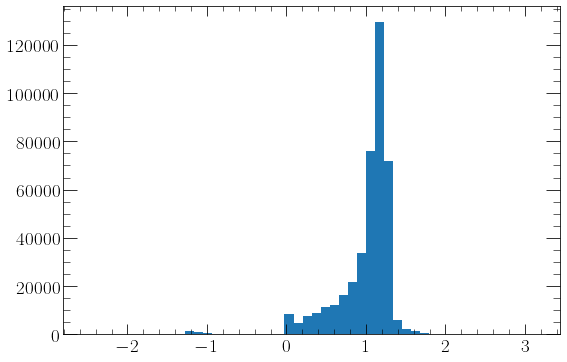

In [32]:
plt.hist(unifold_weights[i], bins=50)

100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


[7.559937223989071e-06, 8.97740218807797e-06, 4.101494793907967e-06, 5.89024254875548e-06, 4.51090896205201e-06, 3.909894193222329e-06, 1.3908486965298177e-05, 8.016829777453789e-06, 5.297510111074003e-06, 1.2782387956491316e-05]
Minimum data distance = 3.909894193222329e-06 at iteration #6


([7.559937223989071e-06,
  8.97740218807797e-06,
  4.101494793907967e-06,
  5.89024254875548e-06,
  4.51090896205201e-06,
  3.909894193222329e-06,
  1.3908486965298177e-05,
  8.016829777453789e-06,
  5.297510111074003e-06,
  1.2782387956491316e-05],
 [1.959682326726619e-06,
  5.742961124976996e-06,
  4.017891412003241e-06,
  4.889425859231513e-06,
  1.585566787684723e-05,
  9.054573320945125e-06,
  4.257488855602541e-06,
  9.374082995938695e-07,
  1.1110992828797415e-06,
  7.036353430522534e-06])

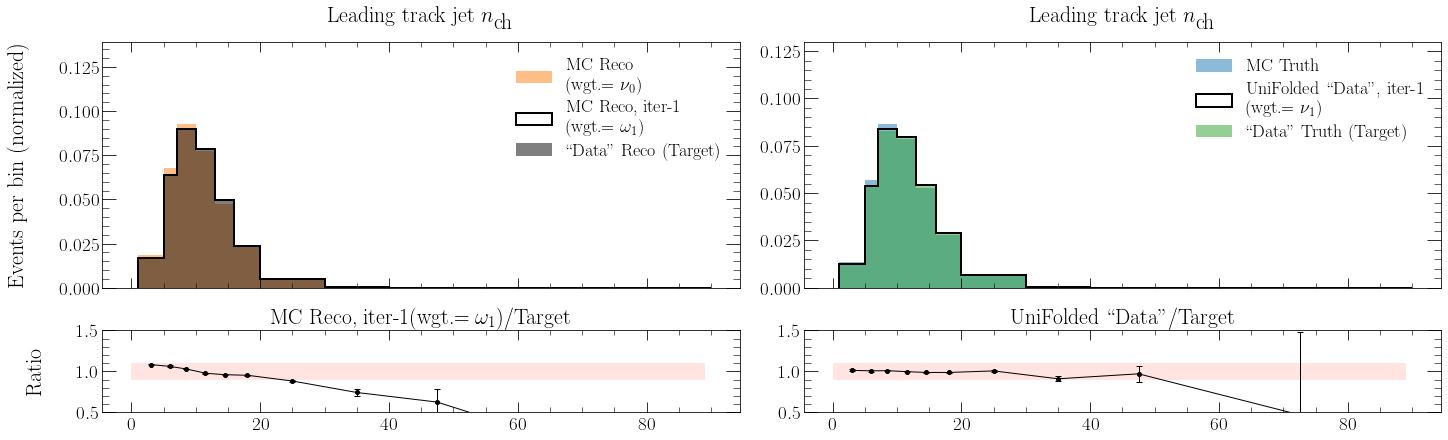

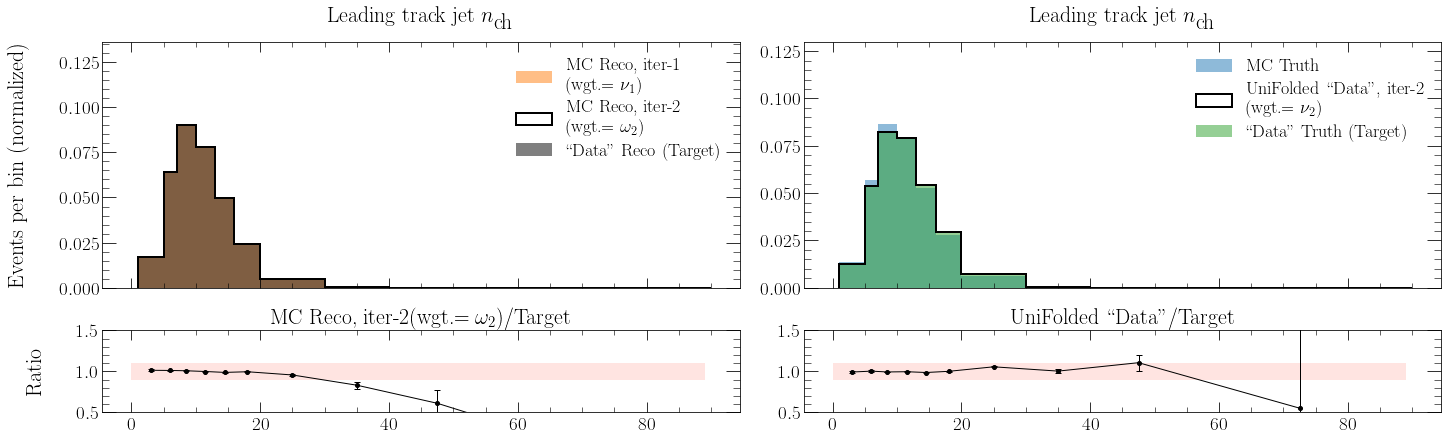

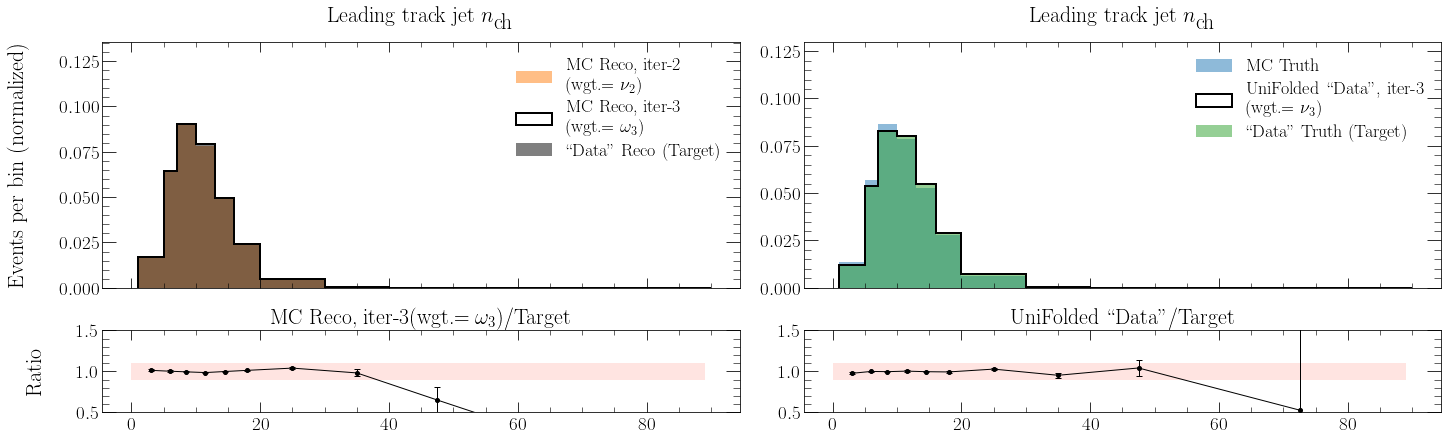

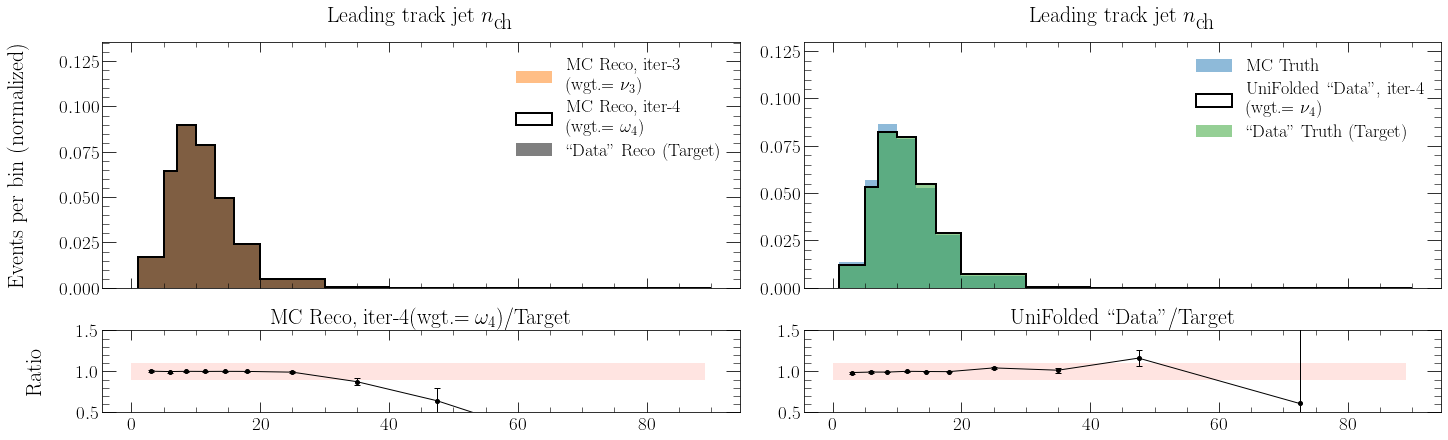

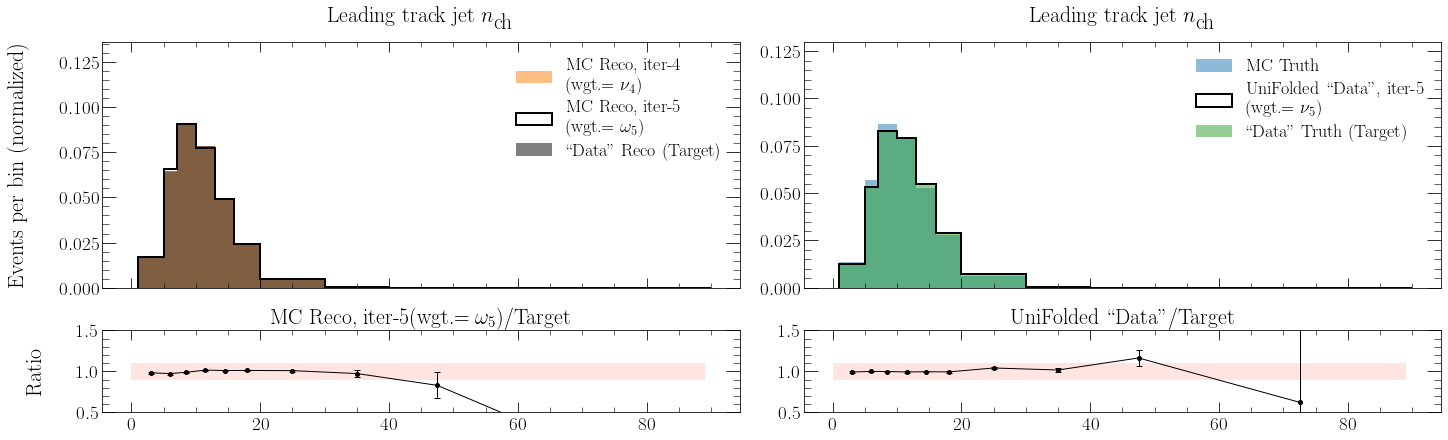

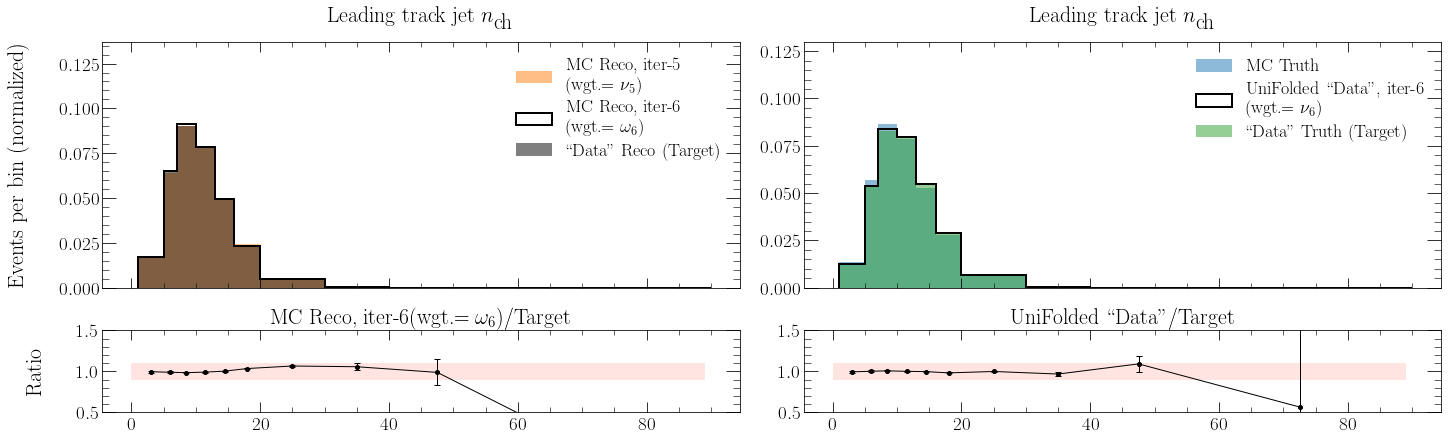

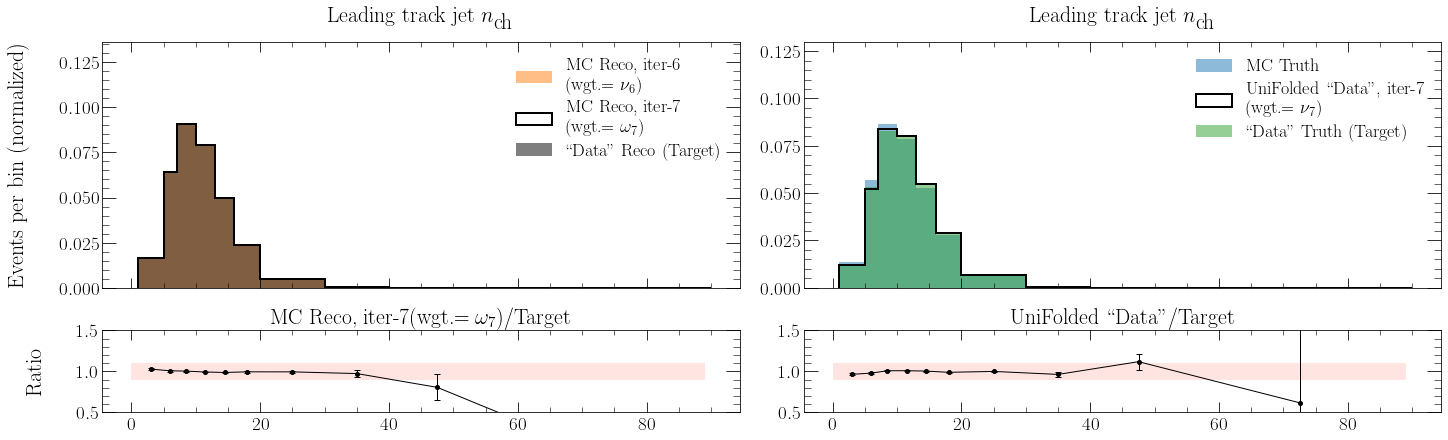

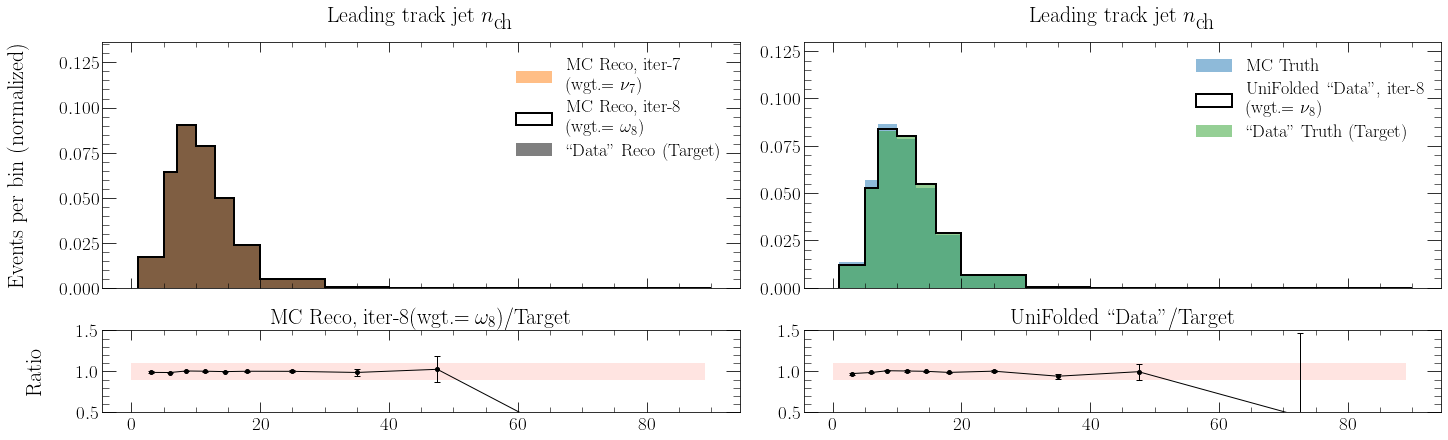

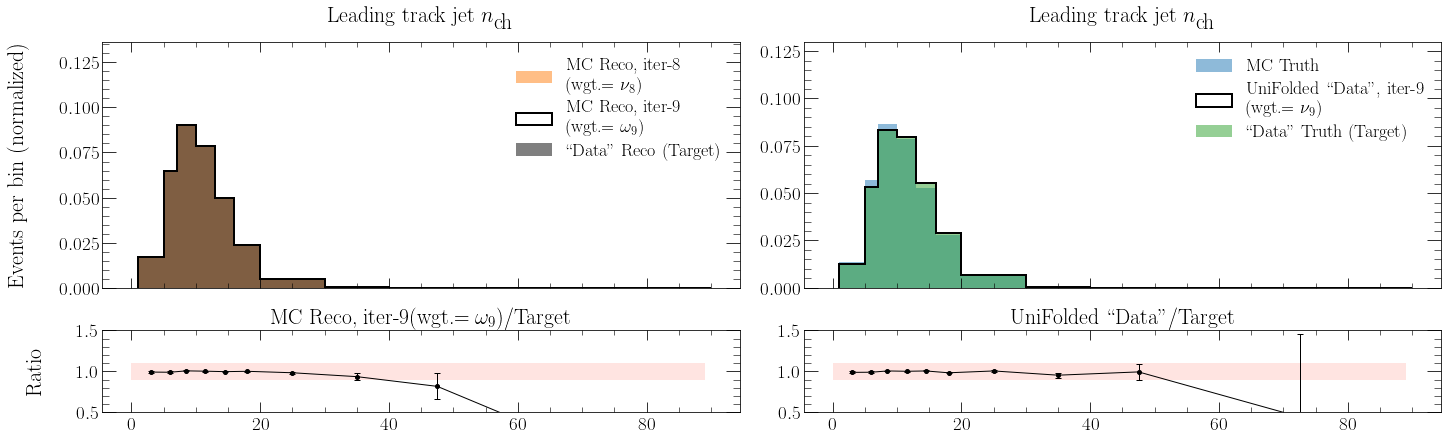

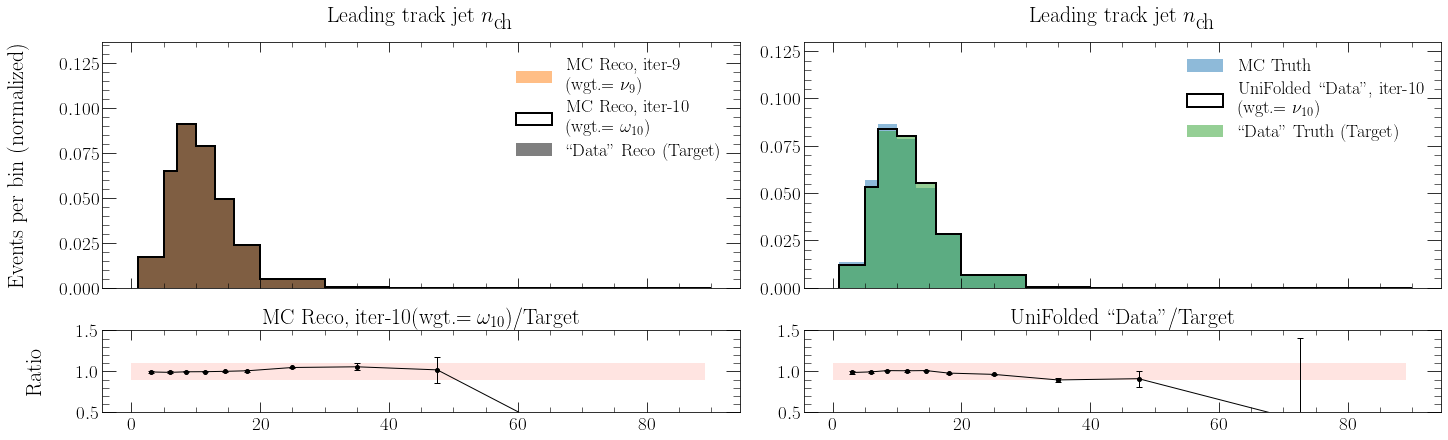

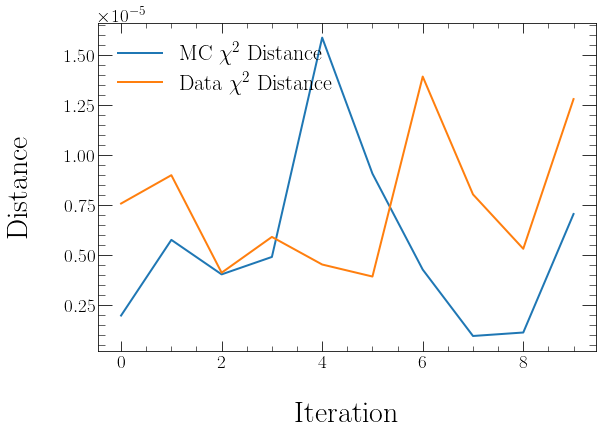

In [33]:
plot_results(sim_truth=mc_truth,
             sim_reco=mc_reco,
             sim_truth_weights_MC=mc_truth_weights,
             sim_reco_weights_MC=mc_reco_weights,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights,
             data_reco_weights_MC=data_reco_weights,
             weights=weights,
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label
            )

Run unfolding multiple times to get a sense of average convergence:

  0%|          | 0/3 [00:00<?, ?it/s]/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/unifold.py:16: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)
  0%|          | 0/3 [00:00<?, ?it/s]/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/unifold.py:16: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)
100%|██████████| 3/3 [01:08<00:00, 22.93s/it]


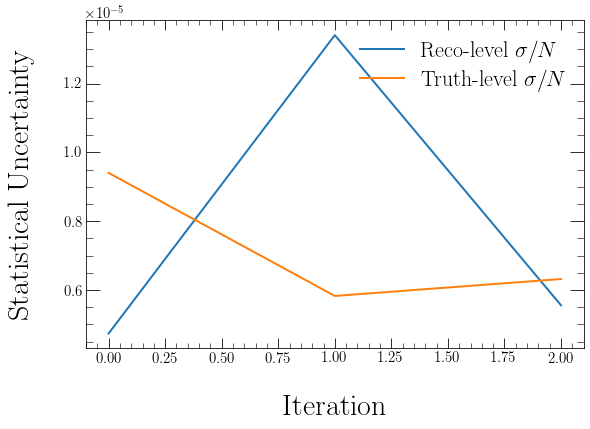

In [36]:
n_trials = 2
n_iterations = 3

all_reco_distances = np.zeros(n_iterations)
all_truth_distances = np.zeros(n_iterations)

for i in range(n_trials):
    
    K.clear_session()
    unifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_truth_weights)))
    i = 0 # index of variable of interest (num_tracks for leading jet)
    bins = ibu_hists[i]['bins']
    x_label = ibu_hists[i]['plot_label']
    file_label = ibu_hists[i]['file_label']
    
    dummyval = -99
    mc_truth = mc[(mc.pass190 | mc.truth_pass190)]['truth_' + file_label]
    mc_truth[mc.truth_pass190 == False] = dummyval
    mc_reco = mc[(mc.pass190 | mc.truth_pass190)][file_label]
    mc_reco[mc.pass190 == False] = dummyval

    data_truth = data[data['truth_pass190']]['truth_' + file_label]
    data_reco = data[data['pass190']][file_label]

    # z-score standardization of data
    mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc_truth), 
                                                   np.array(mc_reco),
                                                   np.array(data_reco))
    
    weights, _ = unifold(iterations=n_iterations,
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc_truth_weights,
                     sim_reco_weights_MC=mc_reco_weights,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights,
                     dummyval=dummyval,
                     verbose=0,
                    )

    reco_distances = []
    truth_distances = []
    for j in range(len(weights)):
        hR1, _ = np.histogram(mc_reco[mc_reco!=dummyval],
                               weights=(mc_reco_weights * weights[j, 0, :])[mc_reco!=dummyval],
                               bins=bins,density=True)
        hR2, _ = np.histogram(data_reco[data_reco!=dummyval],
                               weights=data_reco_weights[data_reco!=dummyval],
                               bins=bins,density=True)
        reco_distances.append(0.5*np.sum((hR1-hR2)**2/(hR1+hR2)))
        
        hT1, _ = np.histogram(mc_truth[mc_truth!=dummyval],
                           weights=(mc_truth_weights * weights[j, 1, :])[mc_truth!=dummyval],
                           bins=bins,density=True)
        if data_truth is not None:
            hT2, _ = np.histogram(data_truth[data_truth!=dummyval],
                               weights=data_truth_weights[data_truth!=dummyval],
                               bins=bins,density=True)
        truth_distances.append(0.5*np.sum((hT1-hT2)**2/(hT1+hT2)))
    
    all_reco_distances += reco_distances
    all_truth_distances += truth_distances

all_reco_distances /= n_trials
all_truth_distances /= n_trials

fig = plt.figure()
plt.plot(np.arange(len(weights)), all_reco_distances, label=r"Reco-level $\sigma/N$", linewidth=2, )
plt.plot(np.arange(len(weights)), all_truth_distances, label=r"Truth-level $\sigma/N$", linewidth=2, )
plt.xlabel("Iteration")
plt.ylabel("Average Statistical Uncertainty")
plt.legend(fontsize=22)

if save_label is not None:
    fig.savefig(save_label + '-ave_stat_uncert.png',
                bbox_inches='tight',
                dpi=100)